In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import cmath
from datetime import datetime
from kneed import KneeLocator
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from dynamical_systems_models import construct_dictionary, embed_signal, perform_stability_analysis, get_stability_results, compute_EDMD, predict_EDMD, compute_VAR_p, compute_VAR_p_over_lamb, predict_VAR_p
from nld_utils import calculate_fnn_stat, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Neural Data 

In [3]:
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [6]:
spike_times = spike_times[0]

In [7]:
dt_orig = dt

# Delayed MI

In [8]:
delayed_mi = pd.read_pickle('__data__/delayed_mi_wake.pkl')

In [9]:
def pick_tau(signal, method='knee'):
    if method == 'local_min':
        local_min_inds = scipy.signal.argrelextrema(signal, np.less)[0]
        if len(local_min_inds) == 0:
            tau = signal.argmin()
        else:
            tau = local_min_inds[0]
    else: # method == 'knee'
        kneedle = KneeLocator(np.arange(len(signal)), signal, S=1, curve='convex', direction='decreasing')
    
    return kneedle.knee

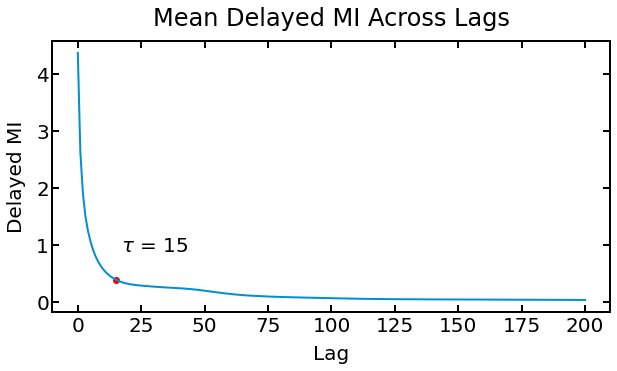

In [10]:
# dim = 23
# tau = pick_tau(delayed_mi[:, dim])
# plt.plot(delayed_mi[:, dim])
# plt.scatter(tau, delayed_mi[tau, dim], c='red')
# plt.xlabel('Lag')
# plt.ylabel('Delayed MI')
# plt.title(f'Delayed MI Dimension {dim}')
# plt.text(tau + 2, delayed_mi[tau, dim] + 0.5, fr"$\tau$ = {tau}")
# plt.show()

mean_delayed_mi = delayed_mi.mean(axis=1)
tau = pick_tau(mean_delayed_mi)

plt.plot(mean_delayed_mi)
plt.scatter(tau, mean_delayed_mi[tau], c='red')
plt.xlabel('Lag')
plt.ylabel('Delayed MI')
plt.title('Mean Delayed MI Across Lags')
plt.text(tau + 2, mean_delayed_mi[tau] + 0.5, fr"$\tau$ = {tau}")
plt.show()

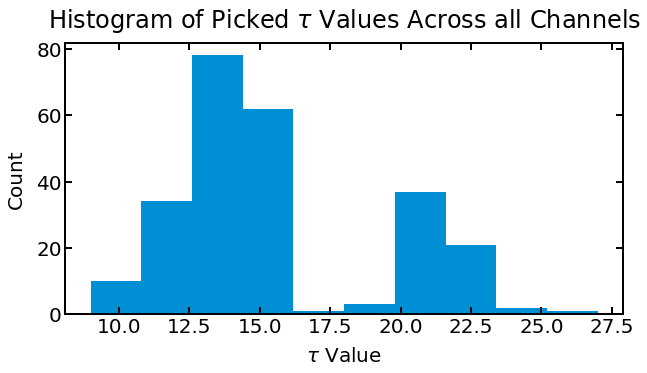

In [11]:
taus = []
for j in range(delayed_mi.shape[1]):
    taus.append(pick_tau(delayed_mi[:, j]))

plt.hist(taus)
plt.xlabel(r'$\tau$ Value')
plt.ylabel('Count')
plt.title(r'Histogram of Picked $\tau$ Values Across all Channels')
plt.show()

In [12]:
lfp_subsampled = lfp[np.arange(0, lfp.shape[0], tau)]

In [13]:
dt = dt_orig*tau

# Class

In [14]:
class KoopmanModels:
    def __init__(self, signal, p=None, svd=True, verbose=False):
        self.signal = signal
        self.window = signal.shape[0]
        self.n = signal.shape[1]
        self.p = p
        
        if p is not None:
            self.compute_hankel(verbose=verbose)
            if svd:
                self.compute_svd(verbose=verbose)
            else:
                self.U = None
                self.S = None
                self.V = None
                self.S_mat = None
                self.S_mat_inv = None
                self.knee = None
        else:
            self.H = None
        
        self.A_var_p = None
        self.H_var_p = None
        self.eigvals_var_p = None
        
        self.r = None
        self.A_havok_dmd = None
        self.V_havok_dmd = None
        self.H_havok_dmd = None
        self.eigvals_havok_dmd = None
        
#         self.A_havok_forcing = None
#         self.B_havok_forcing = None
#         self.V_havok_forcing = None
#         self.H_havok_forcing = None
        
    def compute_hankel(self, p=None, verbose=False):
        if verbose:
            print("Computing Hankel matrix ...")
        if p is None and self.p is None:
            raise ValueError("Embedding dim p has not been provided.")
        elif p is not None:
            self.p = p
        else: # p is None and self.p is not None
            p = self.p
            
        H = embed_signal(self.signal, p, 1, direction='reverse')
        self.H = H
        
        if verbose:
            print("Hankel matrix computed!")
        
    def compute_svd(self, verbose=False):
        if verbose:
            print("Computing SVD on Hankel matrix ...")
        U, S, Vh = np.linalg.svd(self.H.T, full_matrices=False)
        V = Vh.T
        self.U = U
        self.S = S
        self.V = V

        S_mat = np.zeros(U.shape)
        S_mat[np.arange(len(S)), np.arange(len(S))] = S
        self.S_mat = S_mat
        
        S_mat_inv = np.zeros(U.shape)
        S_mat_inv[np.arange(len(S)), np.arange(len(S))] = 1/S
        self.S_mat_inv = S_mat_inv
        
        self.knee = KneeLocator(np.arange(len(S)), S, S=40, curve='convex', direction='decreasing').knee
        
        if verbose:
            print("SVD complete!")
    
    def compute_var_p(self, verbose=False):
        if verbose:
            print("Computing least squares fit to VAR(p) ...")
        coefs = np.linalg.lstsq(self.H[:-1], self.H[1:, :self.n], rcond=1e-14)[0].T
        if verbose:
            print("Least squares complete!")
            print("Constructing transition matrix and train predictions ...")
        A_mat = np.zeros((self.H.shape[1], self.H.shape[1]))
        for i in range(self.p):
            A_mat[:self.n, :][:, i*self.n:(i + 1)*self.n] = coefs[:, i*self.n:(i + 1)*self.n]
            if i < self.p - 1:
                A_mat[(i + 1)*self.n:(i + 2)*self.n, :][:, i*self.n:(i + 1)*self.n] = np.eye(self.n)
        self.A_var_p = A_mat
        H_var_p = (A_mat @ self.H[:-1].T).T
        self.H_var_p = np.vstack([self.H[[0]], H_var_p])
        if verbose:
            print("Train predictions complete!")
            print("Computing eigenvalues ...")
        
        self.eigvals_var_p = np.linalg.eigvals(A_mat)
    
        if verbose:
            print("Eigenvalues computed!")
            
    def compute_havok_dmd(self, r=None, forcing=False, s=1, verbose=False):
        if verbose:
            print("Computing least squares fit to HAVOK DMD ...")
        if r is None:
            r = self.knee*2
        self.r = r
        
        A = np.linalg.lstsq(self.V[:-1, :r], self.V[1:, :r], rcond=1e-14)[0].T
        self.A_havok_dmd = A
        if verbose:
            print("Least squares complete!")
            print("Computing train predictions ...")
        
        V_havok_dmd = (A @ self.V[:-1, :r].T).T
        V_havok_dmd = np.vstack([self.V[[0], :r], V_havok_dmd])
        self.V_havok_dmd = V_havok_dmd
        H_havok_dmd = (self.U @ self.S_mat[:, :r] @ V_havok_dmd.T).T
        self.H_havok_dmd = H_havok_dmd
        
        if verbose:
            print("Train predictions complete!")
            print("Computing eigenvalues ...")
        
        self.eigvals_havok_dmd = np.linalg.eigvals(A)
    
        if verbose:
            print("Eigenvalues computed!")
            
        if forcing:            
            B = A[:r-s, r-s:r]
            A = A[:r-s, :r-s]
            self.A_havok_forcing = A
            self.B_havok_forcing = B
            
#             # not chained
#             V_havok_forcing = (A @ self.V[:-1, :r-s].T).T + (B @ self.V[:-1, r-s:r].T).T
#             V_havok_forcing = np.vstack([self.V[[0], :r-s], V_havok_forcing])
#             self.V_havok_forcing = V_havok_forcing 
            
            # chained
            V_havok_forcing = np.zeros(koopman.V[:, :r-s].shape)
            V_havok_forcing[0] = koopman.V[0, :r-s]
            for t in range(1, koopman.V.shape[0]):
                V_havok_forcing[t] = A @ V_havok_forcing[t-1] + B @ koopman.V[t-1, r-s:r].T
            self.V_havok_forcing = V_havok_forcing
                
            self.H_havok_forcing = (self.U @ self.S_mat[:, :r-s] @ V_havok_forcing.T).T
            
            self.eigvals_havok_forcing = np.linalg.eigvals(A)
            
    def predict_var_p(self, test_signal, tail_bite=False):
        H_test = embed_signal(test_signal, self.p, 1, direction='reverse') 
        
        if tail_bite:
            pass
        else:
            H_test_var_p = (self.A_var_p @ H_test[:-1].T).T
            H_test_var_p = np.vstack([H_test[[0]], H_test_var_p])
        
        return H_test_var_p, H_test

    def predict_havok_dmd(self, test_signal, tail_bite=False):
        H_test = embed_signal(test_signal, self.p, 1, direction='reverse')
        V_test = (self.S_mat_inv[:self.r] @ self.U.T @ H_test.T).T
        
        if tail_bite:
            pass
        else:
            V_test_havok_dmd = (self.A_havok_dmd @ V_test[:-1].T).T
            V_test_havok_dmd = np.vstack([V_test[[0], :self.r], V_test_havok_dmd])
            H_test_havok_dmd = (self.U @ self.S_mat[:, :self.r] @ V_test_havok_dmd.T).T
        
        return H_test_havok_dmd, H_test, V_test_havok_dmd, V_test

# Train

In [199]:
window = 10000
p = 20
window_start = 5000
area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]
n = len(unit_indices)

In [200]:
train_signal = lfp_subsampled[window_start:window_start + window, unit_indices]
# train_signal = lfp[window_start:window_start + window, unit_indices]

In [201]:
%%time
koopman = KoopmanModels(train_signal, p=p, verbose=True)

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
CPU times: user 36.2 s, sys: 543 ms, total: 36.7 s
Wall time: 37.7 s


In [202]:
%%time
koopman.compute_var_p()

CPU times: user 17.6 s, sys: 575 ms, total: 18.2 s
Wall time: 18.7 s


In [203]:
r2_var_p = r2_score(koopman.H[1:, :n], koopman.H_var_p[1:, :n])
r2_persistence_baseline = r2_score(koopman.H[1:, :n], koopman.H[:-1, :n])

In [204]:
T_pred = 500
test_signal = lfp_subsampled[window_start + window - p:window_start + window + T_pred, unit_indices]
# test_signal = lfp[window_start + window - p:window_start + window + T_pred, unit_indices]

In [205]:
H_test_var_p, H_test = koopman.predict_var_p(test_signal)
r2_var_p_test = r2_score(H_test[1:, :n], H_test_var_p[1:, :n])
r2_persistence_baseline_test = r2_score(H_test[1:, :n], H_test[:-1, :n])

In [207]:
r_vals = np.array([int(r) for r in np.linspace(2, koopman.V.shape[1], 30)])

In [209]:
r2_scores = np.zeros(len(r_vals))
r2_scores_test = np.zeros(len(r_vals))
eigvals = []
for i, r in tqdm(enumerate(r_vals), total=len(r_vals)):
    koopman.compute_havok_dmd(r=r)
    r2_scores[i] = r2_score(koopman.H[1:, :n], koopman.H_havok_dmd[1:, :n])
    
    H_test_havok_dmd, _, _, _ = koopman.predict_havok_dmd(test_signal)
    r2_scores_test[i] = r2_score(H_test[1:, :n], H_test_havok_dmd[1:, :n])
    eigvals.append(koopman.eigvals_havok_dmd)

  0%|          | 0/30 [00:00<?, ?it/s]

In [218]:
mean_eigvals = [np.sort(np.abs(vals))[::-1].mean() for vals in eigvals]
mean_eigvals_top_10 = [np.sort(np.abs(vals))[::-1][int(len(vals)/10)].mean() for vals in eigvals]

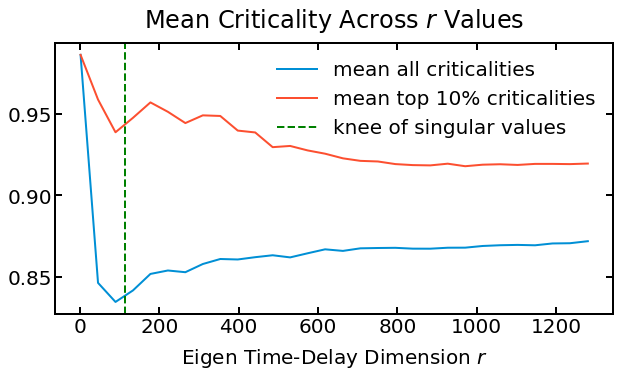

In [221]:
plt.plot(r_vals, mean_eigvals, label='mean all criticalities')
plt.plot(r_vals, mean_eigvals_top_10, label='mean top 10% criticalities')
plt.xlabel('Eigen Time-Delay Dimension $r$')
plt.axvline(koopman.knee, linestyle='--', c='g', label='knee of singular values')
plt.title("Mean Criticality Across $r$ Values")
plt.legend()
plt.show()

In [189]:
# plt.figure(figsize=(12, 8))
# plt.plot(r_vals, r2_scores, label='$R^2$ using HAVOK DMD')
# plt.axhline(r2_var_p, linestyle='--', c='k', label='$R^2$ using VAR(p)')
# plt.axhline(r2_persistence_baseline, linestyle='--', c='gray', label='$R^2$ using persistence baseline')
# plt.xlabel('Eigen Time-Delay Dimension $r$')
# plt.ylabel('R2 Value')
# plt.legend()
# plt.suptitle(f'Training $R^2$\np = {p}, window = {window}')
# plt.tight_layout()
# plt.show()

In [190]:
# plt.figure(figsize=(12, 8))
# plt.plot(r_vals, r2_scores_test, label='$R^2$ using HAVOK DMD')
# plt.axhline(r2_var_p_test, linestyle='--', c='k', label='$R^2$ using VAR(p)')
# plt.axhline(r2_persistence_baseline_test, linestyle='--', c='gray', label='$R^2$ using persistence baseline')
# plt.xlabel('Eigen Time-Delay Dimension $r$')
# plt.ylabel('R2 Value')
# plt.axvline(koopman.knee, linestyle='--', c='g', label='knee of singular values')
# plt.legend()
# plt.suptitle('Testing $R^2$ ($T_{pred}$ = ' + f"{T_pred})\np = {p}, window = {window}")

# plt.tight_layout()
# plt.show()

In [191]:
# start = 0
# end = 150
# plt.plot(np.sort(np.abs(koopman.eigvals_var_p))[::-1][start:end], label='eigenvalues from VAR(p)')
# plt.plot(np.sort(np.abs(koopman.eigvals_havok_dmd))[::-1][start:end], label='eigenvalues from HAVOK DMD')
# plt.show()

In [222]:
koopman.compute_havok_dmd(r=koopman.knee)
H_test_havok_dmd, H_test, _, _ = koopman.predict_havok_dmd(test_signal)

In [223]:
r2_havok_dmd_test = r2_score(H_test[1:, :n], H_test_havok_dmd[1:, :n])

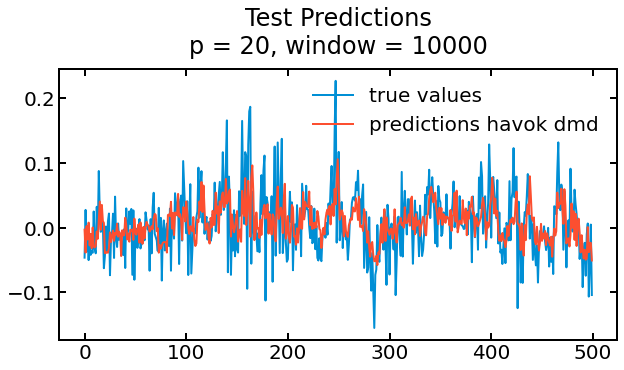

In [224]:
ind = 0
plt.plot(H_test[1:, ind], label='true values')
plt.plot(H_test_havok_dmd[1:, ind], label='predictions havok dmd')
# plt.plot(H_test_var_p[1:, ind], label='predictions var p')
# plt.plot(H_test[:-1, ind], label='persistence baseline', linestyle='--', alpha=0.5)
plt.legend()
# plt.xlim([180, 200])
plt.title(f"Test Predictions\np = {p}, window = {window}")
plt.show()

In [225]:
r2_havok_dmd_test

0.3079515522547371

In [226]:
r2_var_p_test

0.20249499098387136

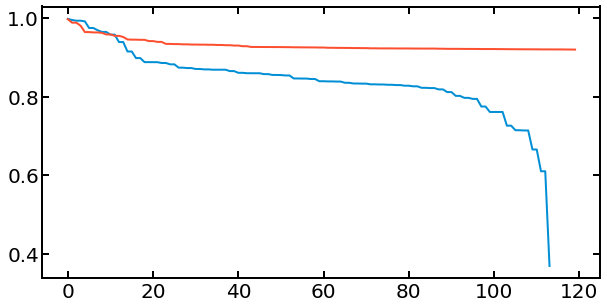

In [228]:
start = 0
end = 120
plt.plot(np.sort(np.abs(koopman.eigvals_havok_dmd))[::-1][start:end])
plt.plot(np.sort(np.abs(koopman.eigvals_var_p))[::-1][start:end])

# Surrogate

In [369]:
surrogate_window = 300 # s
surrogate_window = int(surrogate_window/dt)

lfp_surrogate = np.zeros((surrogate_window, n))
for i in tqdm(range(n)):
    lfp_surrogate[:, i] = surrogates(lfp_subsampled[:surrogate_window, i], ns=1, verbose=False)


  0%|          | 0/64 [00:00<?, ?it/s]

In [390]:
train_signal_surrogate = lfp_surrogate[window_start:window_start + window]

In [391]:
%%time
koopman_surrogate = KoopmanModels(train_signal_surrogate, p=p, verbose=True)

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
CPU times: user 3min 45s, sys: 530 ms, total: 3min 45s
Wall time: 1min 53s


In [392]:
%%time
koopman_surrogate.compute_var_p()

CPU times: user 2min 31s, sys: 1.32 s, total: 2min 32s
Wall time: 1min 17s


In [393]:
r2_var_p_surrogate = r2_score(koopman_surrogate.H[1:, :n], koopman_surrogate.H_var_p[1:, :n])
r2_persistence_baseline_surrogate = r2_score(koopman_surrogate.H[1:, :n], koopman_surrogate.H[:-1, :n])

In [394]:
T_pred = 500
test_signal_surrogate = lfp_surrogate[window_start + window - p:window_start + window + T_pred, unit_indices]

In [395]:
H_test_var_p_surrogate, H_test_surrogate = koopman.predict_var_p(test_signal_surrogate)
r2_var_p_test_surrogate = r2_score(H_test_surrogate[1:, :n], H_test_var_p_surrogate[1:, :n])
r2_persistence_baseline_test_surrogate = r2_score(H_test_surrogate[1:, :n], H_test_surrogate[:-1, :n])

In [399]:
r2_var_p_test, r2_var_p_test_surrogate

(-0.08203773834634413, -7.595242919683165)

In [398]:
koopman_surrogate.compute_havok_dmd(r=koopman_surrogate.knee)
H_test_havok_dmd_surrogate, H_test_surrogate, _, _ = koopman_surrogate.predict_havok_dmd(test_signal_surrogate)
r2_havok_dmd_test_surrogate = r2_score(H_test_surrogate[1:, :n], H_test_havok_dmd_surrogate[1:, :n])

In [400]:
r2_havok_dmd_test, r2_havok_dmd_test_surrogate

(0.3018459318075451, 0.1285400029071344)

In [401]:
H_test_havok_dmd_S2O, _, _, _ = koopman_surrogate.predict_havok_dmd(test_signal)
r2_havok_dmd_test_S2O = r2_score(H_test[1:, :n], H_test_havok_dmd_S2O[1:, :n])

In [403]:
r2_havok_dmd_test_S2O, r2_persistence_baseline_test

(0.006697633515700225, -0.12199972388060801)

In [404]:
H_test_havok_dmd_O2S, _, _, _ = koopman.predict_havok_dmd(test_signal_surrogate)
r2_havok_dmd_test_O2S = r2_score(H_test_surrogate[1:, :n], H_test_havok_dmd_O2S[1:, :n])

In [405]:
r2_havok_dmd_test_O2S

-0.008761138263219344

In [415]:
mean_predictor = np.repeat(H_test[1:, :n].mean(axis=0)[np.newaxis, :], H_test[1:].shape[0], axis=0)

In [416]:
r2_score(H_test[1:, :n], mean_predictor)

0.0

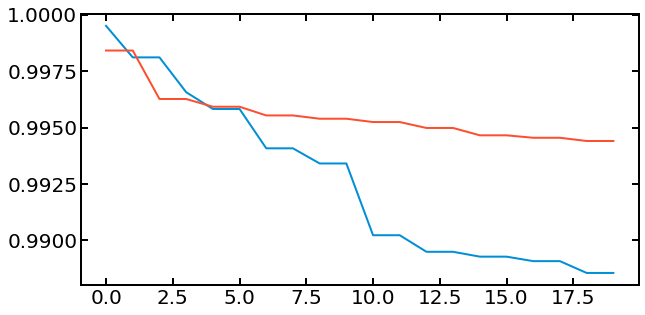

In [421]:
start = 0
end = 20
plt.plot(np.sort(np.abs(koopman.eigvals_havok_dmd))[::-1][start:end])
plt.plot(np.sort(np.abs(koopman_surrogate.eigvals_havok_dmd))[::-1][start:end])
plt.show()

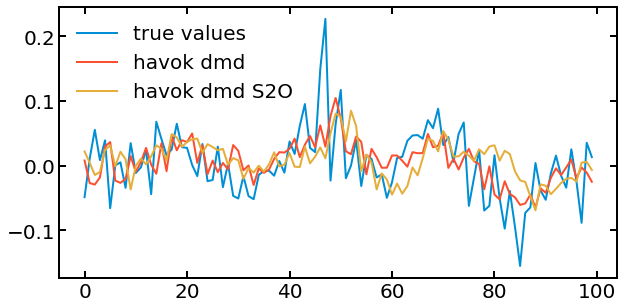

In [429]:
start = 200
end = 300
plt.plot(H_test[1 + start: 1 + end, 0], label='true values')
plt.plot(H_test_havok_dmd[1 + start:1 + end, 0], label='havok dmd')
plt.plot(H_test_havok_dmd_S2O[1 + start: 1 + end, 0], label='havok dmd S2O')
plt.legend()
plt.show()

# derivatives

In [230]:
dt

0.015

In [231]:
koopman.H.shape

(9981, 1280)

In [232]:
H = koopman.H

In [233]:
verbose = True

In [234]:
V = koopman.V
r = koopman.r

In [236]:
r *= 5

In [237]:
time_vals = np.arange(V.shape[0])*dt
dV = np.zeros(V[:, :r].shape)
for k in range(r):
    dV[:, k] = np.gradient(V[:, k], time_vals, edge_order=2)
A = np.linalg.lstsq(V[:, :r], dV, rcond=1e-14)[0].T

In [238]:
# dV = np.zeros((V.shape[0] - 5, r))
# for t in tqdm(range(2, V.shape[0] - 3), disable=not verbose):
#     dV[t-2, :r] = (1/(12*dt))*(-V[t+2, :r] + 8*V[t+1, :r] - 8*V[t-1, :r] + V[t-2, :r])
# A = np.linalg.lstsq(V[2:-3, :r], dV, rcond=1e-14)[0].T

In [239]:
# dH = np.zeros((H.shape[0] - 5, H.shape[1]))
# for t in tqdm(range(2, H.shape[0] - 3), disable=not verbose):
#     dH[t-2, :] = (1/(12*dt))*(-H[t+2, :]+8*H[t+1, :]- 8*H[t-1, :] + H[t-2, :])
# A = np.linalg.lstsq(H[2:-3], dH, rcond=1e-14)[0].T

In [240]:
sys = scipy.signal.lti(A.T, np.zeros((A.shape[0], 1)), np.eye(A.shape[0]), np.zeros((A.shape[0], 1)))

In [241]:
V_recon = np.zeros((V.shape[0], r))
V_recon[0] = V[0, :r]
for t in tqdm(range(1, V_recon.shape[0])):
    T, yout, xout = scipy.signal.lsim(sys, np.zeros(2), np.arange(2)*dt, X0 = V[t - 1, :r])
    V_recon[t] = yout[-1]

  0%|          | 0/9980 [00:00<?, ?it/s]

KeyboardInterrupt: 

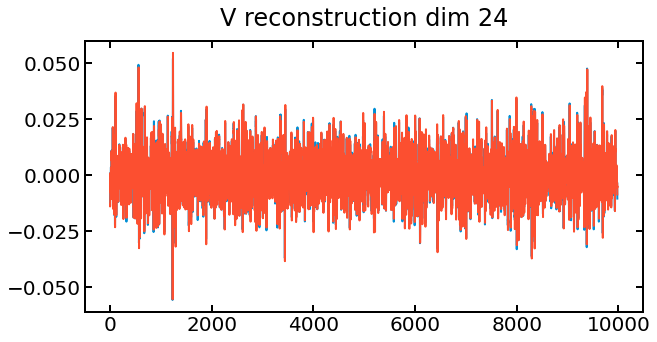

In [152]:
ind = 24
plt.plot(V[:, ind])
plt.plot(V_recon[:, ind])
plt.title(f"V reconstruction dim {ind}")
plt.show()

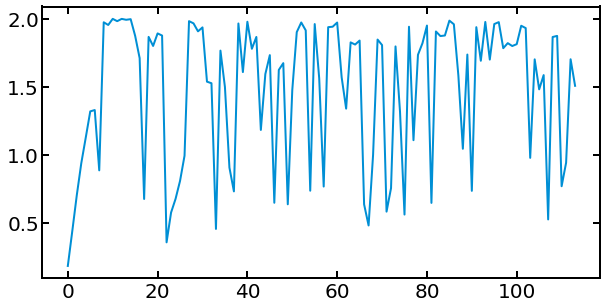

In [154]:
plt.plot(np.linalg.norm(V_recon - V[:, :r], axis=0))

In [155]:
H_recon = (koopman.U @ koopman.S_mat[:, :r] @ V_recon.T).T

In [156]:
r2_score(H[1:, :n], H_recon[1:, :n])

0.22183926680867713

In [157]:
r2_score(H_smol[:200, 0], H_recon[1:201, 0])

0.04016209856919106

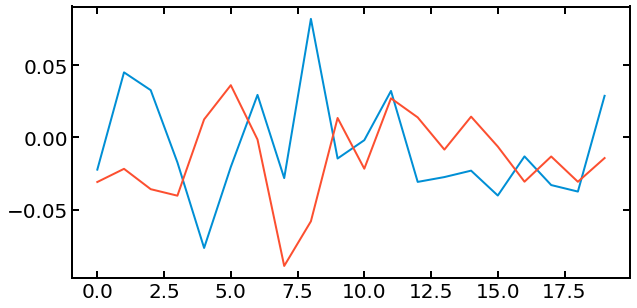

In [158]:
plt.plot(H_smol[:20, 0])
plt.plot(H_recon[:20, 0])
plt.show()

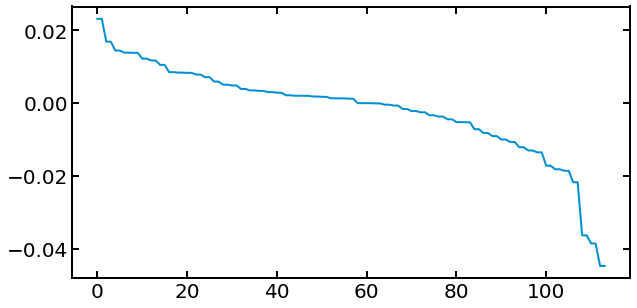

In [159]:
plt.plot(np.sort(np.real(np.linalg.eigvals(A)))[::-1])

In [160]:
# H_recon = np.zeros((H.shape[0] - 5, H.shape[1]))
# H_recon[0] = H[2]
# for t in tqdm(range(1, H_recon.shape[0])):
#     T, yout, xout = scipy.signal.lsim(sys, np.zeros(2), np.arange(2)*dt, X0 = H[t-1])
#     H_recon[t] = yout[-1]

In [161]:
r2_score(H[:20, :n], H_recon[:20, :n])

-0.43781063187678065

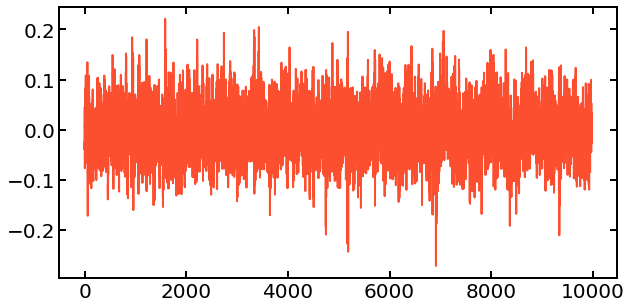

In [162]:
plt.plot(yout[:, 0])
plt.plot(H[:, 0])

In [45]:
T, yout, xout = scipy.signal.lsim(sys, np.zeros(2), np.arange(2)*dt, X0 = H[0])

In [48]:
yout.shape

(2, 1280)

In [50]:
yout[0] - H[0], yout[1] - H[1]

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.01625028, 0.05240279, 0.03446062, ..., 0.01188773, 0.00730448,
        0.0066169 ]))